In [ ]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.patches as patches
import seaborn as sns
import pandas as pd
import itertools


import time
from collections import defaultdict, Counter
import torch

from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchvision.models import resnet50
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)
from malaria_dataset import MalariaDataset, detection_collate

# Dataset Preparation

In [2]:
# Paths
root_path = os.path.join('..', 'dataset', 'malaria')
train_json_path = os.path.join(root_path, 'training.json')
test_json_path = os.path.join(root_path, 'test.json')
image_path = os.path.join(root_path, 'images')
print("Root Path:", root_path)
print("Train JSON Path:", train_json_path)
print("Test JSON Path:", test_json_path)
print("Image Path:", image_path)

Root Path: ..\dataset\malaria
Train JSON Path: ..\dataset\malaria\training.json
Test JSON Path: ..\dataset\malaria\test.json
Image Path: ..\dataset\malaria\images


In [ ]:
models_dir = os.path.join('.', 'resnet_models') 
os.makedirs(models_dir, exist_ok=True) 

print(f"Models will be saved in: {models_dir}")

Models will be saved in: .\resnet_models


Counting Images

In [4]:
image_path = os.path.join('..', 'dataset', 'malaria', 'images')

# Check if the image directory exists
if not os.path.exists(image_path):
    print(f"Error: The image path '{image_path}' does not exist.")
else:
    # Use defaultdict to simplify counting
    image_sizes = defaultdict(int)
    
    # Get a list of all files in the directory
    image_files = os.listdir(image_path)
    
    # Iterate through the files and get the size of each image
    for filename in image_files:
        # Construct the full path to the image file
        full_path = os.path.join(image_path, filename)
        
        # Check if the file is a regular file and not a directory
        if os.path.isfile(full_path):
            try:
                # Open the image file using Pillow
                with Image.open(full_path) as img:
                    # Get the size (width, height) of the image
                    width, height = img.size
                    
                    # Increment the count for this specific size
                    image_sizes[(width, height)] += 1
            except Exception as e:
                # Handle cases where the file is not a valid image
                print(f"Could not open image file: {filename} - {e}")
    
    # Print the counts for each image size
    print("Image size counts:")
    for size, count in image_sizes.items():
        print(f"Size: {size[0]}x{size[1]}, Count: {count}")

Image size counts:
Size: 1600x1200, Count: 1208
Size: 1944x1383, Count: 120


Counting Json images

In [5]:
# Function to count entries in a JSON file
def count_json_entries(file_path):
    if not os.path.exists(file_path):
        print(f"Error: The file path '{file_path}' does not exist.")
        return 0
    
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    # Assuming the JSON data is a list of entries
    return len(data)

# Count entries in each file
train_count = count_json_entries(train_json_path)
test_count = count_json_entries(test_json_path)

# Print the results
print(f"Number of entries in training.json: {train_count}")
print(f"Number of entries in test.json: {test_count}")

Number of entries in training.json: 1208
Number of entries in test.json: 120


Visualizing data distribution

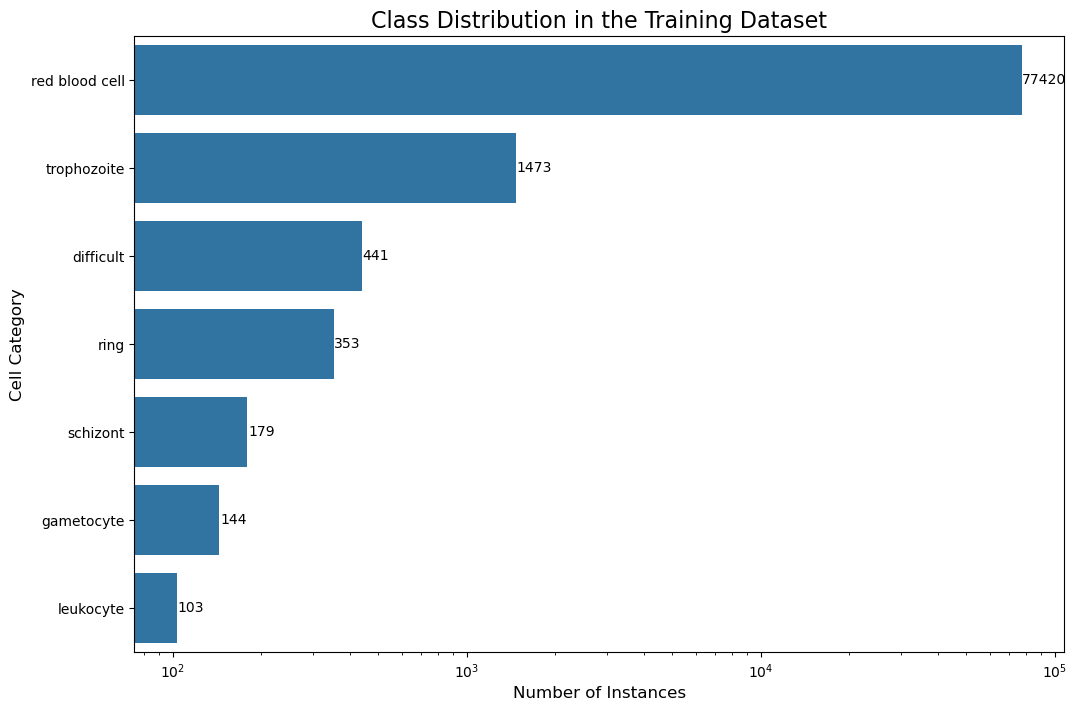

In [ ]:
def ploting_cells_count(training_dataset_json):
  # Loading the JSON
  with open(training_dataset_json, 'r') as f:
      training_metadata = json.load(f)

  # Extracting all object categories into a list
  all_categories = []
  for item in training_metadata:
      for obj in item['objects']:
          all_categories.append(obj['category'])

  df = pd.DataFrame(all_categories, columns=['category'])

  #   Plotting  
  plt.figure(figsize=(12, 8))
  ax = sns.countplot(y='category', data=df, order=df['category'].value_counts().index)
  plt.title('Class Distribution in the Training Dataset', fontsize=16)
  plt.xlabel('Number of Instances', fontsize=12)
  plt.ylabel('Cell Category', fontsize=12)
  # Use a log scale for the x-axis due to the large imbalance
  plt.xscale('log')

  for p in ax.patches:
      width = p.get_width()
      y = p.get_y() + p.get_height() / 2

      # Adding the text to the plot
      ax.text(width + 1,  # Positioning the text slightly to the right of the bar
              y,
              f'{int(width)}', # Displaying count
              ha='left',      # Horizontal alignment
              va='center')    # Vertical alignment
  plt.show()

ploting_cells_count(train_json_path)

## B. Deeplearning

### Sampler

In [ ]:
# function to create a sampler for handling class imbalance
def create_sampler(dataset):
    """Creates a WeightedRandomSampler to oversample minority classes."""
    # Count frequency of each class in the dataset
    class_counts = Counter(dataset.labels)
    
    # Remove placeholder labels if any
    if -1 in class_counts:
        del class_counts[-1]
        
    print("Class distribution:", class_counts)

    # Calculate weight for each class (more weight to rare classes)
    num_samples = len(dataset.labels)
    class_weights = {cls: num_samples / count for cls, count in class_counts.items()}
    
    # Assign a weight to each sample in the dataset
    sample_weights = [class_weights.get(label, 0) for label in dataset.labels]

    # Create the sampler
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    return sampler


### 1. Resnet50

In [ ]:
class ResNetDetector(nn.Module):
    # Your ResNetDetector class here...
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = resnet50(weights='IMAGENET1K_V1')
        # Replace the final fully connected layer
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity() # Remove the original classifier

        # New heads for task
        self.classifier = nn.Linear(num_features, num_classes)
        self.bbox_head = nn.Linear(num_features, 4)

    def forward(self, x):
        features = self.backbone(x)
        class_scores = self.classifier(features)
        bbox_preds = self.bbox_head(features)
        return class_scores, bbox_preds


In [ ]:
# Your loss functions and collate_fn here...
def margin_loss(class_scores, targets, margin=0.2):
    one_hot_targets = F.one_hot(targets.long(), num_classes=class_scores.size(-1)).float()
    left = F.relu(margin - class_scores) * one_hot_targets
    right = F.relu(class_scores - (1 - margin)) * (1.0 - one_hot_targets)
    return (left + right).sum(dim=-1).mean()

def bbox_loss(preds, targets):
    if preds.dim() == 1:
        preds = preds.unsqueeze(0)
    num_preds, num_targets = preds.size(0), targets.size(0)
    if num_preds > num_targets:
        padding = torch.zeros((num_preds - num_targets, 4), device=targets.device)
        targets = torch.cat([targets, padding], dim=0)
    elif num_targets > num_preds:
        padding = torch.zeros((num_targets - num_preds, 4), device=preds.device)
        preds = torch.cat([preds, padding], dim=0)
    return F.smooth_l1_loss(preds, targets)

In [ ]:
# Your train and validate functions here...
def train_model(model, train_loader, optimizer, epoch, device, image_size):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    pbar = tqdm(train_loader, desc=f"Training Epoch {epoch}", unit="batch")
    for images, targets_list in pbar:
        images = images.to(device)
        optimizer.zero_grad()

        class_scores, bbox_preds = model(images)
        
        batch_class_loss = 0
        batch_bbox_loss = 0
        
        for i in range(images.size(0)):
            target = targets_list[i]
            target_boxes = target['boxes'].to(device)
            target_labels = target['labels'].to(device)
            
            if len(target_labels) == 0: continue
            
            # Normalize bounding boxes
            target_boxes_norm = target_boxes / torch.tensor([image_size, image_size, image_size, image_size], device=device)

            batch_class_loss += margin_loss(class_scores[i].unsqueeze(0), target_labels)
            batch_bbox_loss += bbox_loss(bbox_preds[i], target_boxes_norm)

            predicted = torch.argmax(class_scores[i])
            correct += (predicted == target_labels).sum().item()
            total += len(target_labels)
        
        loss = batch_class_loss + 0.1 * batch_bbox_loss
        if total > 0:
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total if total > 0 else 0
    print(f"Train Epoch: {epoch}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")
    return epoch_loss, accuracy

def validate_model(model, val_loader, device, image_size): 
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, targets_list in tqdm(val_loader, desc="Validating", unit="batch"):
            images = images.to(device)
            class_scores, bbox_preds = model(images)

            for i in range(images.size(0)):
                target = targets_list[i]
                target_boxes = target['boxes'].to(device)
                target_labels = target['labels'].to(device)
                
                if len(target_labels) == 0: continue
                
                target_boxes_norm = target_boxes / torch.tensor([image_size, image_size, image_size, image_size], device=device)

                loss = margin_loss(class_scores[i].unsqueeze(0), target_labels) + \
                       0.1 * bbox_loss(bbox_preds[i], target_boxes_norm)
                running_loss += loss.item()
                
                predicted = torch.argmax(class_scores[i])
                correct += (predicted == target_labels).sum().item()
                total += len(target_labels)

    epoch_loss = running_loss / len(val_loader)
    accuracy = 100 * correct / total if total > 0 else 0
    print(f"Validation Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")
    return epoch_loss, accuracy



In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(history, params):
    """Saves a plot of training and validation metrics vs. epochs."""
    
    #   Create a unique filename for the plot  
    plot_filename = (f"metrics_lr_{params['lr']}_optim_{params['optimizer']}_"
                    f"sampling_{params['sampling']}_size_{params['image_size']}.png")
    save_path = os.path.join(models_dir, plot_filename)

    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    #   Plot Loss  
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-o', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-o', label='Validation Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    #   Plot Accuracy  
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_accuracy'], 'b-o', label='Training Accuracy')
    plt.plot(epochs, history['val_accuracy'], 'r-o', label='Validation Accuracy')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(save_path)
    plt.close() # Close the figure to free up memory
    print(f"Metrics plot saved to {save_path}")

In [ ]:
def run_experiment(params):
    """
    Runs a full training and validation experiment for a given set of hyperparameters.
    """
    print("\n" + "="*50)
    print(f"STARTING EXPERIMENT with params: {params}")
    print("="*50)

    start_time = time.time()

    #   1. Setup Device and Create Transforms based on params  
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image_size = params['image_size']

    
    train_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    test_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    #   2. Create Datasets and DataLoaders  
    train_ds = MalariaDataset(train_json_path, image_path, transform=train_transform, image_size=image_size)
    test_ds = MalariaDataset(test_json_path, image_path, transform=test_transform, category_map=train_ds.category_map, image_size=image_size)
    
    sampler = None
    shuffle = True
    if params['sampling'] == 'oversample':
        print("Applying weighted oversampling...")
        sampler = create_sampler(train_ds)
        shuffle = False

    train_loader = DataLoader(
        train_ds, batch_size=params['batch_size'], shuffle=shuffle, sampler=sampler,
        collate_fn=detection_collate, 
        num_workers=0
    )
    val_loader = DataLoader(
        test_ds, batch_size=params['batch_size'], shuffle=False, 
        collate_fn=detection_collate, 
        num_workers=0
    )

    #   3. Initialize Model and Optimizer  
    model = ResNetDetector(num_classes=len(train_ds.category_map)).to(device)
    optimizer = optim.Adam(model.parameters(), lr=params['lr']) if params['optimizer'] == 'Adam' \
        else optim.SGD(model.parameters(), lr=params['lr'], momentum=0.9)

    #   4. Training Loop  
    best_val_accuracy = 0.0
    num_epochs = 10
    best_val_accuracy = 0.0
    num_epochs = 10 
    
    #   (1) INITIALIZE HISTORY  
    history = {
        'train_loss': [], 'train_accuracy': [],
        'val_loss': [], 'val_accuracy': []
    }
    
    for epoch in range(1, num_epochs + 1):
        # Pass image_size to your train/validate functions if they need it for normalization
        train_loss, train_accuracy = train_model(model, train_loader, optimizer, epoch, device, image_size)
        val_loss, val_accuracy = validate_model(model, val_loader, device, image_size)

        #   (2) RECORD METRICS EACH EPOCH  
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_accuracy)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            print(f"New best model! Val Accuracy: {best_val_accuracy:.2f}%")
            
            #   5. Save the best model for this experiment  
            model_filename = (f"model_lr_{params['lr']}_optim_{params['optimizer']}_"
                            f"sampling_{params['sampling']}_size_{params['image_size']}.pth")
            save_path = os.path.join(models_dir, model_filename)

            torch.save({
                'model_state_dict': model.state_dict(),
                'best_val_accuracy': best_val_accuracy,
                'params': params
            }, save_path)
            print(f"Model saved to {save_path}")

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Finished experiment. Best validation accuracy: {best_val_accuracy:.2f}%")
    print(f"Total training time: {elapsed_time / 60:.2f} minutes")
    
    # plot_metrics(history, params)
    return {
        'params': params,
        'best_accuracy': best_val_accuracy,
        'training_time_minutes': elapsed_time / 60,
        'history' : history
    }

In [ ]:
#   Helper function to manage results  
def get_completed_experiments(results_path):
    """Loads existing results and returns a set of completed parameter combos."""
    if not os.path.exists(results_path):
        return set(), []
    
    with open(results_path, 'r') as f:
        try:
            existing_results = json.load(f)
        except json.JSONDecodeError:
            return set(), [] # File is empty or corrupt

    # Create a unique, hashable representation of each param dictionary
    completed = set(tuple(sorted(res['params'].items())) for res in existing_results)
    print(f"Found {len(completed)} completed experiments in {results_path}.")
    return completed, existing_results

In [ ]:

if __name__ == '__main__':
    # Define the grid of hyperparameters to search
    param_grid = {
        'lr': [0.001, 0.0001],
        'optimizer': ['Adam', 'SGD'],
        'batch_size': [32],
        'sampling': ['none', 'oversample'],
        'image_size': [128, 224] # <-- EXPERIMENT WITH SIZES
    }
    results_path = os.path.join(models_dir, 'grid_search_results.json')
    
    #   2. Generate all experiment configurations  
    keys, values = zip(*param_grid.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    #   3. Load previous progress (CHECKPOINTING)  
    completed_params, all_results = get_completed_experiments(results_path)
    
    print(f"Starting Grid Search. Total experiments to run: {len(experiments)}")
 #   4. Run the experiments  
    for i, params in enumerate(experiments):
        # Create a unique key for the current parameter set
        current_param_key = tuple(sorted(params.items()))

        # Check if this experiment has already been completed
        if current_param_key in completed_params:
            print(f"\n  Skipping Experiment {i+1}/{len(experiments)} (already done)  ")
            print(f"Params: {params}")
            continue

        # If not skipped, run the experiment
        print(f"\n  Running Experiment {i+1}/{len(experiments)}  ")
        result = run_experiment(params)
        all_results.append(result)

        #   5. Save progress after EACH experiment (CHECKPOINTING)  
        try:
            with open(results_path, 'w') as f:
                json.dump(all_results, f, indent=4)
            print(f"Progress saved to {results_path}")
        except Exception as e:
            print(f"Error saving progress: {e}")


    #   6. Print and save final results  
    print("\n\n" + "#"*30)
    print("GRID SEARCH COMPLETE")
    print("#"*30)
    
    sorted_results = sorted(all_results, key=lambda x: x.get('best_accuracy', 0), reverse=True)
    
    for res in sorted_results:
        print(f"Acc: {res.get('best_accuracy', 0):.2f}% | "
              f"Time: {res.get('training_time_minutes', 0):.2f} min | "
              f"Params: {res.get('params', {})}")

    print(f"\nAll results saved to {results_path}")

Found 14 completed experiments in .\resnet_models\grid_search_results.json.
Starting Grid Search. Total experiments to run: 16

--- Skipping Experiment 1/16 (already done) ---
Params: {'lr': 0.001, 'optimizer': 'Adam', 'batch_size': 32, 'sampling': 'none', 'image_size': 128}

--- Skipping Experiment 2/16 (already done) ---
Params: {'lr': 0.001, 'optimizer': 'Adam', 'batch_size': 32, 'sampling': 'none', 'image_size': 224}

--- Skipping Experiment 3/16 (already done) ---
Params: {'lr': 0.001, 'optimizer': 'Adam', 'batch_size': 32, 'sampling': 'oversample', 'image_size': 128}

--- Skipping Experiment 4/16 (already done) ---
Params: {'lr': 0.001, 'optimizer': 'Adam', 'batch_size': 32, 'sampling': 'oversample', 'image_size': 224}

--- Skipping Experiment 5/16 (already done) ---
Params: {'lr': 0.001, 'optimizer': 'SGD', 'batch_size': 32, 'sampling': 'none', 'image_size': 128}

--- Skipping Experiment 6/16 (already done) ---
Params: {'lr': 0.001, 'optimizer': 'SGD', 'batch_size': 32, 'samplin

Training Epoch 1: 100%|██████████| 38/38 [03:20<00:00,  5.29s/batch, loss=12.2503]


Train Epoch: 1, Loss: 20.0301, Accuracy: 90.60%


Validating: 100%|██████████| 4/4 [00:11<00:00,  2.90s/batch]


Validation Loss: 18.4156, Accuracy: 94.80%
New best model! Val Accuracy: 94.80%
Model saved to .\resnet_models\model_lr_0.0001_optim_SGD_sampling_oversample_size_128.pth


Training Epoch 2: 100%|██████████| 38/38 [02:53<00:00,  4.56s/batch, loss=12.3184]


Train Epoch: 2, Loss: 16.1177, Accuracy: 84.65%


Validating: 100%|██████████| 4/4 [00:08<00:00,  2.10s/batch]


Validation Loss: 18.5833, Accuracy: 94.80%


Training Epoch 3: 100%|██████████| 38/38 [02:50<00:00,  4.49s/batch, loss=12.1757]


Train Epoch: 3, Loss: 16.0528, Accuracy: 83.14%


Validating: 100%|██████████| 4/4 [00:08<00:00,  2.17s/batch]


Validation Loss: 18.4293, Accuracy: 94.80%


Training Epoch 4: 100%|██████████| 38/38 [02:56<00:00,  4.64s/batch, loss=12.1387]


Train Epoch: 4, Loss: 15.9234, Accuracy: 74.78%


Validating: 100%|██████████| 4/4 [00:08<00:00,  2.24s/batch]


Validation Loss: 17.9650, Accuracy: 94.80%


Training Epoch 5: 100%|██████████| 38/38 [02:56<00:00,  4.64s/batch, loss=12.0000]


Train Epoch: 5, Loss: 15.8654, Accuracy: 74.85%


Validating: 100%|██████████| 4/4 [00:08<00:00,  2.15s/batch]


Validation Loss: 17.7253, Accuracy: 90.90%


Training Epoch 6: 100%|██████████| 38/38 [02:54<00:00,  4.60s/batch, loss=11.8343]


Train Epoch: 6, Loss: 15.8001, Accuracy: 80.55%


Validating: 100%|██████████| 4/4 [00:08<00:00,  2.13s/batch]


Validation Loss: 17.7130, Accuracy: 86.90%


Training Epoch 7: 100%|██████████| 38/38 [02:47<00:00,  4.41s/batch, loss=11.8736]


Train Epoch: 7, Loss: 15.9645, Accuracy: 79.48%


Validating: 100%|██████████| 4/4 [00:08<00:00,  2.10s/batch]


Validation Loss: 17.7004, Accuracy: 89.41%


Training Epoch 8: 100%|██████████| 38/38 [02:47<00:00,  4.40s/batch, loss=12.0019]


Train Epoch: 8, Loss: 15.8166, Accuracy: 71.78%


Validating: 100%|██████████| 4/4 [00:08<00:00,  2.13s/batch]


Validation Loss: 18.1247, Accuracy: 93.53%


Training Epoch 9: 100%|██████████| 38/38 [02:48<00:00,  4.44s/batch, loss=11.8170]


Train Epoch: 9, Loss: 15.7453, Accuracy: 71.12%


Validating: 100%|██████████| 4/4 [00:08<00:00,  2.12s/batch]


Validation Loss: 18.8768, Accuracy: 80.78%


Training Epoch 10: 100%|██████████| 38/38 [02:47<00:00,  4.42s/batch, loss=11.9121]


Train Epoch: 10, Loss: 15.7546, Accuracy: 71.10%


Validating: 100%|██████████| 4/4 [00:08<00:00,  2.10s/batch]


Validation Loss: 18.4109, Accuracy: 91.02%
Finished experiment. Best validation accuracy: 94.80%
Total training time: 30.59 minutes
Progress saved to .\resnet_models\grid_search_results.json

--- Running Experiment 16/16 ---

STARTING EXPERIMENT with params: {'lr': 0.0001, 'optimizer': 'SGD', 'batch_size': 32, 'sampling': 'oversample', 'image_size': 224}
Applying weighted oversampling...
Class distribution: Counter({3: 1186, 6: 6, 4: 5, 0: 5, 5: 4, 1: 2})


Training Epoch 1: 100%|██████████| 38/38 [05:39<00:00,  8.94s/batch, loss=6.5172] 


Train Epoch: 1, Loss: 9.6664, Accuracy: 86.81%


Validating: 100%|██████████| 4/4 [00:14<00:00,  3.54s/batch]


Validation Loss: 9.7571, Accuracy: 94.80%
New best model! Val Accuracy: 94.80%
Model saved to .\resnet_models\model_lr_0.0001_optim_SGD_sampling_oversample_size_224.pth


Training Epoch 2: 100%|██████████| 38/38 [05:42<00:00,  9.01s/batch, loss=6.2274]


Train Epoch: 2, Loss: 8.4235, Accuracy: 69.52%


Validating: 100%|██████████| 4/4 [00:14<00:00,  3.75s/batch]


Validation Loss: 9.7217, Accuracy: 91.78%


Training Epoch 3: 100%|██████████| 38/38 [05:53<00:00,  9.32s/batch, loss=6.3371]


Train Epoch: 3, Loss: 8.3669, Accuracy: 71.04%


Validating: 100%|██████████| 4/4 [00:14<00:00,  3.73s/batch]


Validation Loss: 9.8202, Accuracy: 91.54%


Training Epoch 4: 100%|██████████| 38/38 [05:50<00:00,  9.22s/batch, loss=6.1672]


Train Epoch: 4, Loss: 8.3234, Accuracy: 68.84%


Validating: 100%|██████████| 4/4 [00:14<00:00,  3.73s/batch]


Validation Loss: 9.6633, Accuracy: 75.30%


Training Epoch 5: 100%|██████████| 38/38 [05:51<00:00,  9.24s/batch, loss=6.2275]


Train Epoch: 5, Loss: 8.3242, Accuracy: 41.30%


Validating: 100%|██████████| 4/4 [00:15<00:00,  3.81s/batch]


Validation Loss: 9.6073, Accuracy: 74.06%


Training Epoch 6: 100%|██████████| 38/38 [05:49<00:00,  9.21s/batch, loss=6.2215]


Train Epoch: 6, Loss: 8.3180, Accuracy: 59.85%


Validating: 100%|██████████| 4/4 [00:15<00:00,  3.76s/batch]


Validation Loss: 9.6281, Accuracy: 94.04%


Training Epoch 7: 100%|██████████| 38/38 [05:51<00:00,  9.24s/batch, loss=6.3747]


Train Epoch: 7, Loss: 8.3176, Accuracy: 43.35%


Validating: 100%|██████████| 4/4 [00:15<00:00,  3.81s/batch]


Validation Loss: 9.6978, Accuracy: 94.80%


Training Epoch 8: 100%|██████████| 38/38 [05:55<00:00,  9.35s/batch, loss=6.3409]


Train Epoch: 8, Loss: 8.2921, Accuracy: 47.87%


Validating: 100%|██████████| 4/4 [00:14<00:00,  3.74s/batch]


Validation Loss: 9.5252, Accuracy: 88.72%


Training Epoch 9: 100%|██████████| 38/38 [05:49<00:00,  9.20s/batch, loss=6.2537]


Train Epoch: 9, Loss: 8.2927, Accuracy: 42.51%


Validating: 100%|██████████| 4/4 [00:14<00:00,  3.73s/batch]


Validation Loss: 9.5897, Accuracy: 94.80%


Training Epoch 10: 100%|██████████| 38/38 [05:55<00:00,  9.34s/batch, loss=6.2562]


Train Epoch: 10, Loss: 8.2644, Accuracy: 44.27%


Validating: 100%|██████████| 4/4 [00:14<00:00,  3.73s/batch]

Validation Loss: 9.6061, Accuracy: 81.81%
Finished experiment. Best validation accuracy: 94.80%
Total training time: 60.82 minutes
Progress saved to .\resnet_models\grid_search_results.json


##############################
GRID SEARCH COMPLETE
##############################
Acc: 94.80% | Time: 31.35 min | Params: {'lr': 0.001, 'optimizer': 'Adam', 'batch_size': 32, 'sampling': 'none', 'image_size': 128}
Acc: 94.80% | Time: 81.28 min | Params: {'lr': 0.001, 'optimizer': 'Adam', 'batch_size': 32, 'sampling': 'none', 'image_size': 224}
Acc: 94.80% | Time: 31.81 min | Params: {'lr': 0.001, 'optimizer': 'Adam', 'batch_size': 32, 'sampling': 'oversample', 'image_size': 128}
Acc: 94.80% | Time: 61.68 min | Params: {'lr': 0.001, 'optimizer': 'Adam', 'batch_size': 32, 'sampling': 'oversample', 'image_size': 224}
Acc: 94.80% | Time: 31.51 min | Params: {'lr': 0.001, 'optimizer': 'SGD', 'batch_size': 32, 'sampling': 'none', 'image_size': 128}
Acc: 94.80% | Time: 61.93 min | Params: {'lr': 0.001, 